In [27]:
import io
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid 
from torchvision.models import resnet50, ResNet50_Weights
import lightning as L
import torch.nn.functional as F
from torchmetrics.classification import BinaryF1Score, BinaryConfusionMatrix
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import PIL.Image
from torchvision.transforms import ToTensor
import numpy as np
import seaborn as sns

## Hyperparameters

In [28]:
BATCH_SIZE = 32
SHUFFLE = False # Warning message that it should be turned off for train/val loaders check later
NUM_WORERS = 7 # 7 because that what it suggested in a warning message
PERSISTENT_WORKERS = True # Suggested to do this in a warning message for fatser init

CUSTOM_TRAIN_VAL_SPLIT = True
TRAIN_FRACTION = 0.8
VALIDATION_FRACTION = 1 - TRAIN_FRACTION

LEARNING_RATE = 1e-3
EPOCHS = 2

## Load data

In [29]:
CLASS_LABELS = ["Normal", "Pneumonia"]
DATA_DIR = "chest_xray" # Change this to chest_xray folder
data_dir_train = DATA_DIR + "/train"
data_dir_val = DATA_DIR + "/val"
data_dir_test = DATA_DIR + "/test"

# Some desired transforms for ResNet50
# https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50
transform = transforms.Compose(
    [
        transforms.Resize(size = (256, 256)),
        transforms.CenterCrop(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # 
    ]
)
dataset_train = datasets.ImageFolder(data_dir_train, transform)
dataset_val = datasets.ImageFolder(data_dir_val, transform)

if CUSTOM_TRAIN_VAL_SPLIT:
    dataset = torch.utils.data.ConcatDataset([dataset_train, dataset_val])
    dataset_train, dataset_val = torch.utils.data.random_split(dataset, [TRAIN_FRACTION, VALIDATION_FRACTION])

dataset_test = datasets.ImageFolder(data_dir_test, transform)

train_loader = DataLoader(
    dataset_train, 
    batch_size=BATCH_SIZE, 
    shuffle=SHUFFLE, 
    num_workers=NUM_WORERS, 
    persistent_workers= PERSISTENT_WORKERS
)
val_loader = DataLoader(
    dataset_val, 
    batch_size=BATCH_SIZE, 
    shuffle=SHUFFLE, 
    num_workers=NUM_WORERS, 
    persistent_workers= PERSISTENT_WORKERS
)
test_loader = DataLoader(
    dataset_test, 
    batch_size=BATCH_SIZE, 
    shuffle=SHUFFLE, 
    num_workers=NUM_WORERS, 
    persistent_workers= PERSISTENT_WORKERS
)

## Plot some example images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


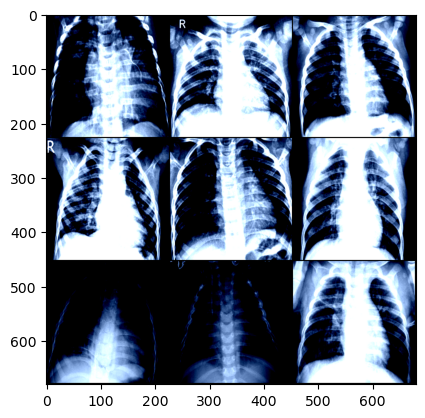

In [30]:
examples = next(iter(train_loader))
images, labels = examples
grid = make_grid(images[:9], nrow=3)
plt.imshow(grid.permute(1, 2, 0))

## Load ResNet50 model

In [31]:
#Load best resNet50 weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)

#Change output layer to 2 classes
model.fc = torch.nn.Linear(
    in_features=2048,
    out_features=2,
    bias=True
)

#Freeze all layers except fc
for name, param in model.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

## Create Lightning module

In [32]:
class Classificator(L.LightningModule):
    def __init__(self, rn50, class_labels):
        super().__init__()
        self.rn50 = rn50
        self.class_labels = class_labels
        self.f1_metric = BinaryF1Score()
        self.confusion_matrix = BinaryConfusionMatrix()

    def training_step(self, batch):
        images, labels = batch
        output = self.rn50(images)
        _, preds = torch.max(output, dim=1)
        loss = F.cross_entropy(output, labels) # Quickfix check if BCE is better later
        f1_score = self.f1_metric(preds, labels)
        train_acc = torch.sum(preds == labels) / len(labels) # Batch acc fix later to epoch acc
        self.log_dict({"Traning loss" : loss, "Training accuracy" : train_acc, "Train F1 Score" : f1_score}, prog_bar=True)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        output = self.rn50(images)
        loss = F.cross_entropy(output, labels) # Quickfix check if BCE is better later
        _, preds = torch.max(output, dim=1)
        val_acc = torch.sum(preds == labels) / len(labels) # Batch acc fix later to epoch acc
        f1_score = self.f1_metric(preds, labels)
        self.log_dict({"Validation loss" : loss, "Validation accuracy": val_acc, "Validation F1 Score" : f1_score}, prog_bar=True)

    def test_step(self, batch):
        images, labels = batch
        output = self.rn50(images)
        loss = F.cross_entropy(output, labels) # Quickfix check if BCE is better later
        _, preds = torch.max(output, dim=1)
        test_acc = torch.sum(preds == labels) / len(labels) # Batch acc fix later to epoch acc
        f1_score = self.f1_metric(preds, labels)
        self.confusion_matrix.update(preds, labels)
        self.log_dict({"Test loss" : loss, "Test accuracy": test_acc, "Test F1 Score" : f1_score}, prog_bar=True)

    def on_test_end(self):
        cm = self.confusion_matrix.compute()
        image = self.transform_confusion_matrix(cm)
        self.logger.experiment.add_image("Confusion matrix test results", image)

    # Takes a tensor and plot confusion matrix from it and then return as tensor
    def transform_confusion_matrix(self, cm):
        cm = cm.cpu().numpy()
        fig = plt.figure()
        sns.heatmap(cm, annot=True, xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS, fmt="g", cbar=False)
        buf = io.BytesIO()
        fig.savefig(buf, format='png')
        buf.seek(0)
        image = PIL.Image.open(buf)
        image = ToTensor()(image)
        return image


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

## Run training and validation loops

In [33]:
classifier = Classificator(model, CLASS_LABELS)
early_stop_callback = EarlyStopping(monitor="Validation loss", min_delta=1e-6, patience=3)
checkpoint = L.pytorch.callbacks.ModelCheckpoint(dirpath="pneumonia_model/ResNet/")
callbacks = [early_stop_callback, checkpoint]

trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=EPOCHS,
    callbacks=callbacks
)
trainer.fit(
    model = classifier,
    train_dataloaders = train_loader, 
    val_dataloaders = val_loader
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/emillundin/Desktop/D7047E/D7047E-Project/D7047E-Project/pneumonia_model/ResNet exists and is not empty.

  | Name             | Type                  | Params
-----------------------------------------------------------
0 | rn50             | ResNet                | 23.5 M
1 | f1_metric        | BinaryF1Score         | 0     
2 | confusion_matrix | BinaryConfusionMatrix | 0     
-----------------------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


## Test model

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test F1 Score       │    0.6325105428695679     │
│       Test accuracy       │    0.7948718070983887     │
│         Test loss         │    0.42260339856147766    │
└───────────────────────────┴───────────────────────────┘

[{'Test loss': 0.42260339856147766,
  'Test accuracy': 0.7948718070983887,
  'Test F1 Score': 0.6325105428695679}]

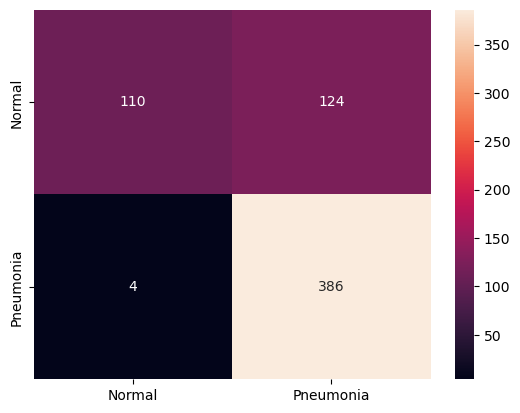

In [34]:
trainer.test(
    model = classifier, 
    dataloaders=test_loader
)

In [35]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Reusing TensorBoard on port 6006 (pid 53915), started 0:19:15 ago. (Use '!kill 53915' to kill it.)